In [1]:
#Imports

import os
import cv2
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
if os.getenv("COLAB_RELEASE_TAG"):
    isInColab = True
else:
    isInColab = False

if isInColab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    data_folder_path = Path(os.getcwd() + r"/gdrive/My Drive/FoodSeg103/Images")
    models_path = Path(os.getcwd() + r"/gdrive/My Drive/Models")
else:
    data_folder_path = Path(os.getcwd()+ r"/Dataset/FoodSeg103/Images")
    models_path = Path(os.getcwd() + r"/Models")
try:
    os.mkdir(models_path)
    print("Models folder created for saving models")
except:
    print("Models folder already exists")

Mounted at /content/gdrive
Models folder already exists


In [3]:
def loadImages(NUM_TRAIN_IMAGES, NUM_VAL_IMAGES):
    train_images_path = os.path.join(data_folder_path, r"img_dir/train")
    train_ann_path = os.path.join(data_folder_path, r"ann_dir/train")
    test_images_path = os.path.join(data_folder_path, r"img_dir/test")
    test_ann_path = os.path.join(data_folder_path, r"ann_dir/test")
    train_images_paths = sorted(os.listdir(train_images_path))
    train_ann_paths = sorted(os.listdir(train_ann_path))
    test_images_paths = sorted(os.listdir(test_images_path))
    test_ann_paths = sorted(os.listdir(test_ann_path))

    train_images = train_images_paths[:NUM_TRAIN_IMAGES]
    train_masks = train_ann_paths[:NUM_TRAIN_IMAGES]
    val_images = test_images_paths[:NUM_VAL_IMAGES]
    val_masks = test_ann_paths[:NUM_VAL_IMAGES]

    train_images = [str(os.path.join(train_images_path, img)) for img in train_images]
    train_masks = [str(os.path.join(train_ann_path, img)) for img in train_masks]
    val_images = [str(os.path.join(test_images_path, img)) for img in val_images]
    val_masks = [str(os.path.join(test_ann_path, img)) for img in val_masks]

    images = {
        "train_images": train_images,
        "train_masks": train_masks,
        "val_images": val_images,
        "val_masks": val_masks,
    }
    return images

In [4]:
#Data Function definitions

def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE], method='nearest')
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [5]:
#Model definitons

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", kernel_initializer=keras.initializers.HeNormal())(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [14]:
def plotHistory(history):
    plt.plot(history.history["loss"])
    plt.title("Training Loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()

    plt.plot(history.history["accuracy"])
    plt.title("Training Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.show()

    plt.plot(history.history["val_loss"])
    plt.title("Validation Loss")
    plt.ylabel("val_loss")
    plt.xlabel("epoch")
    plt.show()

    plt.plot(history.history["val_accuracy"])
    plt.title("Validation Accuracy")
    plt.ylabel("val_accuracy")
    plt.xlabel("epoch")
    plt.show()

def predict(model, images, index, useTrainingImages):
    ImageIndex = index

    if useTrainingImages:
      img_path = images["train_images"][ImageIndex]
      ann_path = images["train_masks"][ImageIndex]
    else:
      img_path = images["val_images"][ImageIndex]
      ann_path = images["val_masks"][ImageIndex]

    processed_image = read_image(img_path)[None,:,:,:]
    result = model.predict(processed_image)
    result = result.squeeze()
    return result

def plotPrediction(model, images, index, useTrainingImages):
    ImageIndex = index

    if useTrainingImages:
      img_path = images["train_images"][ImageIndex]
      ann_path = images["train_masks"][ImageIndex]
    else:
      img_path = images["val_images"][ImageIndex]
      ann_path = images["val_masks"][ImageIndex]

    print(img_path)
    print(ann_path)

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    ans = cv2.cvtColor(cv2.imread(ann_path), cv2.COLOR_BGR2RGB)
    ans = cv2.resize(ans, dsize=(256, 256), interpolation = cv2.INTER_NEAREST)

    newAnn = np.zeros((IMAGE_SIZE,IMAGE_SIZE))
    for i in range(IMAGE_SIZE):
      for j in range(IMAGE_SIZE):
        newAnn[i][j] = np.max(ans[i][j])

    processed_image = read_image(img_path)[None,:,:,:]
    old = model.predict(processed_image)
    old = old.squeeze()
    new = np.zeros((IMAGE_SIZE,IMAGE_SIZE))
    for i in range(IMAGE_SIZE):
      for j in range(IMAGE_SIZE):
        new[i][j] = np.argmax(old[i][j])

    fig, axs = plt.subplots(2, 2)
    axs[0,0].imshow(img)
    axs[0,0].set_title("Image")
    axs[1,0].imshow(ans);
    axs[1,0].set_title("True labels")
    axs[0,1].imshow(newAnn);
    axs[0,1].set_title("True labels recolored")
    axs[1,1].imshow(new);
    axs[1,1].set_title("Model (top1) predictions")
    fig.set_figwidth(7)
    fig.set_figheight(7)
    fig.show()
    return (img, ans, newAnn, new)

def debug(images):
    #Debug used earlier, probably safe to delete THE TWO PICTURES SHOULD BE THE SAME LABEL PICTURE
    max = 0
    for ans_path in images["train_masks"]:
      candidate = np.max(cv2.imread(ans_path))
      if candidate > max:
        max = candidate
        max_img = cv2.imread(ans_path)
        max_path = ans_path
    print(ans_path)
    print(max)
    plt.imshow(max_img)
    plt.show()
    ans = cv2.cvtColor(max_img, cv2.COLOR_BGR2RGB)
    ans = cv2.resize(ans, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    plt.imshow(ans)
    plt.show()
    return

def trainNewModel(Epochs):
    #Train new model and history
    model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.002),
        loss=loss,
        metrics=["accuracy"],
    )
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=Epochs)
    return (model, history)

def loadModel():
    print("Input the folder of the model to load (the folder should be in the models folder and include a history.npy file and a model.keras file):")
    load_name = input()
    folder_load_path = os.path.join(models_path, Path(load_name))
    his_load_path = os.path.join(folder_load_path, Path(r"history.npy"))
    model_load_path = os.path.join(folder_load_path, Path(r"model.keras"))
    history=np.load(his_load_path,allow_pickle='TRUE').item()
    model = keras.models.load_model(model_load_path)
    return (model, history)

def saveModel(model, history):
    dt_string = datetime.now().strftime("%d%m%Y-%H:%M:%S")
    save_name = "model_" + dt_string
    folder_save_path = os.path.join(models_path, Path(save_name))
    os.mkdir(folder_save_path)
    his_save_path = os.path.join(folder_save_path, Path(r"history.npy"))
    model_save_path = os.path.join(folder_save_path, Path(r"model.keras"))
    np.save(his_save_path,history)
    model.save(model_save_path)

In [7]:
##Constants
IMAGE_SIZE = 256
BATCH_SIZE = 16
NUM_CLASSES = 104

#Load images (note this can take some time since it loads the whole folder, even if only using a small subset of the images)
images = loadImages(2048, 512)

In [8]:
#Was the data loaded correctly?
for ans_path in images["train_images"]:
  print(ans_path)

#Check whether we have another device than the cpu
print(tf.config.list_physical_devices())

#Check whether the images are in the correct format
train_dataset = data_generator(images["train_images"], images["train_masks"])
val_dataset = data_generator(images["val_images"], images["val_masks"])

#One batch of training images, training answers, validation images and validation answers
print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000000.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000001.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000002.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000003.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000004.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000005.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000006.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000007.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000008.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000009.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000010.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000011.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000012.jpg
/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000013.jpg
/content/gdrive/My D

In [9]:
#model, history = trainNewModel(32)
#saveModel(model, history)

Input the folder of the model to load (the folder should be in the models folder and include a history.npy file and a model.keras file):
Initial32Epoch
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 

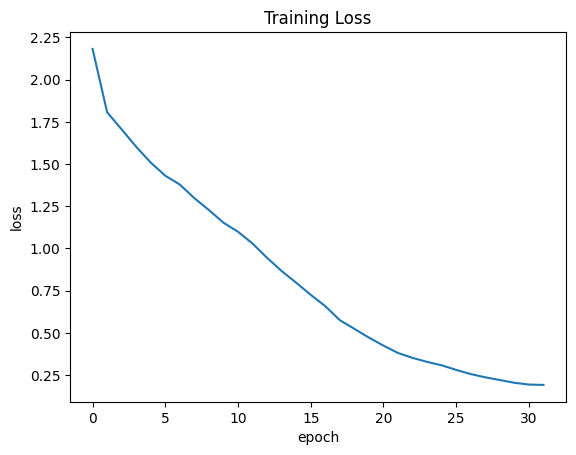

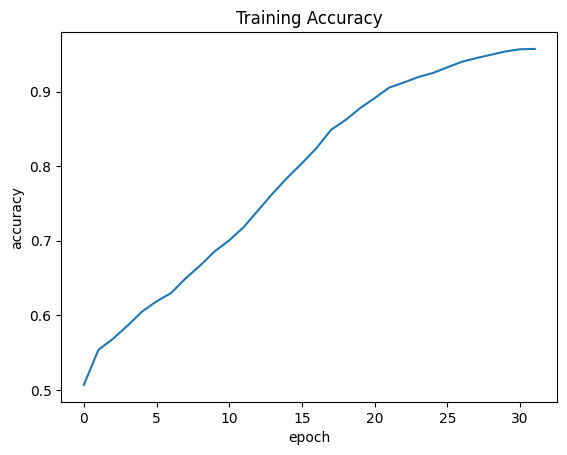

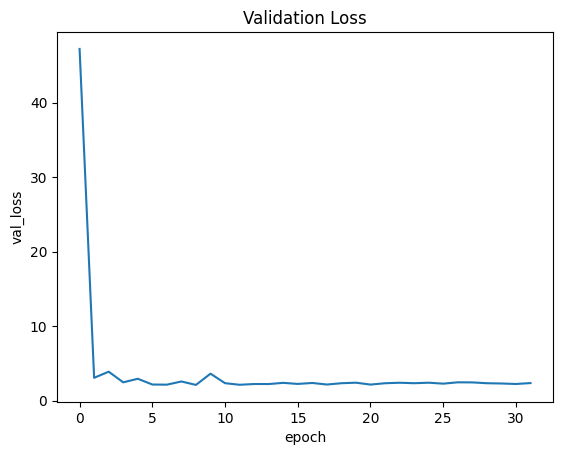

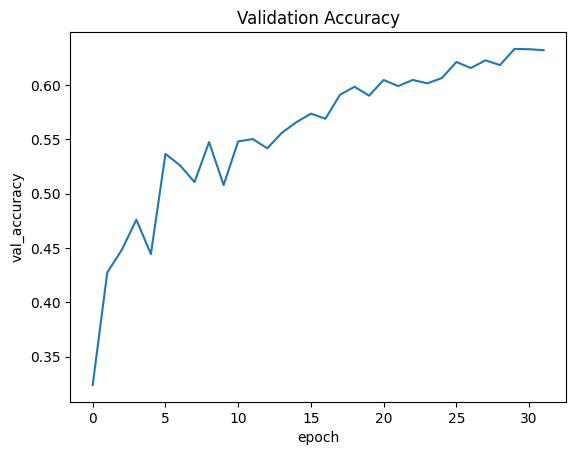

In [10]:
model, history = loadModel()
model.summary()
plotHistory(history)

/content/gdrive/My Drive/FoodSeg103/Images/img_dir/train/00000000.jpg
/content/gdrive/My Drive/FoodSeg103/Images/ann_dir/train/00000000.png
1/1 [==============================] - 0s 27ms/step


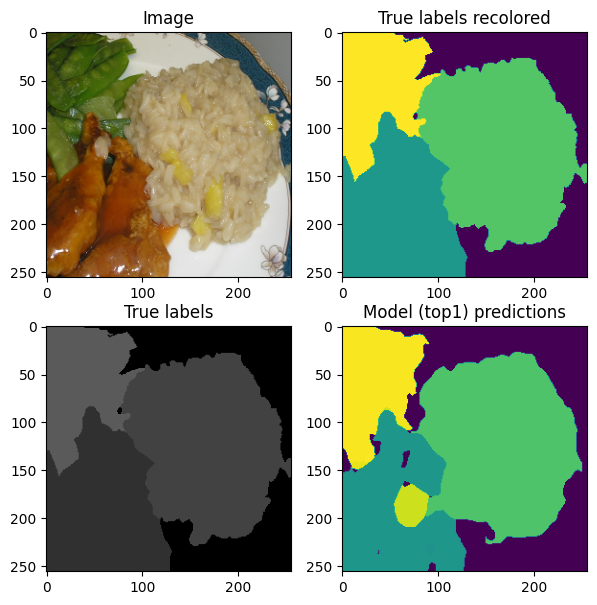

In [16]:
#Load model, print model, show a single prediction and plot the training history
ImageI = 0
(originalImage, trueLabels, trueLabelsRecolored, predictions) = plotPrediction(model, images, ImageI, True)
rawPrediction = predict(model, images, ImageI, True)

In [26]:
p = (0,0)
print(trueLabels[p])
print(trueLabelsRecolored[p])
print(rawPrediction[p])
print(rawPrediction[p].max())
print(np.argmax(rawPrediction[p]))
print("top 5:")
print(np.argpartition(rawPrediction[p], -5)[-5:])

[90 90 90]
90.0
[  3.1066225   -6.2755003   -7.880875    -6.011418    -5.2577558
  -6.4858317   -5.8262534   -5.7672095   -6.518983    -8.129232
  -4.2156157   -2.5402393   -4.496731    -3.9283586   -4.5896316
  -5.2469635   -3.9754517   -5.209003    -4.2161655   -5.835784
  -3.6661441   -5.1320004   -2.8044465   -4.393912    -5.6515026
  -5.0193267   -5.689228    -6.307565    -4.2860475   -2.0158257
  -2.0067332   -5.347237    -6.620596    -5.8204775   -4.5346804
  -4.485325    -1.5462967   -5.0262938   -5.056736    -6.7385707
  -1.2926784   -1.043845    -0.24841253  -4.492329    -3.131755
  -2.422004    -8.65494     -6.665369    -7.2900205  -10.648298
  -6.593274    -5.9487286   -9.010304    -7.035999   -10.274287
  -6.283308    -8.323979    -7.9734073   -9.505927    -4.3884726
  -4.359816    -9.46531     -5.9216704   -3.899923    -5.9303
  -9.303296    -5.9750614  -10.104472    -5.3948545   -6.2547483
  -6.1819496   -4.1609426   -3.89879     -2.7329185   -3.609989
  -5.0873613   -2.

In [13]:
read_image("/content/gdrive/My Drive/FoodSeg103/Images/ann_dir/train/00000000.png", True)[p]

<tf.Tensor: shape=(1,), dtype=uint8, numpy=array([48], dtype=uint8)>